# Определение стоимости автомобилей. Проект по спринту "Численнные методы"

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

## Подготовка данных

In [1]:
pip install --upgrade scikit-learn

Note: you may need to restart the kernel to use updated packages.


In [2]:
!pip install phik

In [3]:
#импорт библиотек и инструментов
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LinearRegression
import lightgbm as lgb
from sklearn.metrics import mean_squared_error
import time
import pandas as pd
import phik
from phik import resources, report
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer

In [4]:
# загрузка и просмотр данных
data = pd.read_csv('/datasets/autos.csv')
display(data.head())
display(data.info())

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

None

In [5]:
# приведение названий столбцов к змеиному регистру
data.columns = data.columns.str.lower().str.replace(' ', '_')

data.rename(columns={
    'datecrawled': 'date_crawled',
    'vehicletype': 'vehicle_type',
    'registrationyear': 'registration_year',
    'registrationmonth': 'registration_month',
    'fueltype': 'fuel_type',
    'datecreated': 'date_created',
    'numberofpictures': 'number_of_pictures',
    'postalcode': 'postal_code',
    'lastseen': 'last_seen'    
}, inplace=True)

# проверка
display(data.columns)

Index(['date_crawled', 'price', 'vehicle_type', 'registration_year', 'gearbox',
       'power', 'model', 'kilometer', 'registration_month', 'fuel_type',
       'brand', 'repaired', 'date_created', 'number_of_pictures',
       'postal_code', 'last_seen'],
      dtype='object')

In [6]:
# осмотр данных
display(data.head())
display(data.info())

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired,date_created,number_of_pictures,postal_code,last_seen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   date_crawled        354369 non-null  object
 1   price               354369 non-null  int64 
 2   vehicle_type        316879 non-null  object
 3   registration_year   354369 non-null  int64 
 4   gearbox             334536 non-null  object
 5   power               354369 non-null  int64 
 6   model               334664 non-null  object
 7   kilometer           354369 non-null  int64 
 8   registration_month  354369 non-null  int64 
 9   fuel_type           321474 non-null  object
 10  brand               354369 non-null  object
 11  repaired            283215 non-null  object
 12  date_created        354369 non-null  object
 13  number_of_pictures  354369 non-null  int64 
 14  postal_code         354369 non-null  int64 
 15  last_seen           354369 non-null  object
dtypes:

None

In [7]:
#посмотрим на количество пропусков
data.isnull().sum()

date_crawled              0
price                     0
vehicle_type          37490
registration_year         0
gearbox               19833
power                     0
model                 19705
kilometer                 0
registration_month        0
fuel_type             32895
brand                     0
repaired              71154
date_created              0
number_of_pictures        0
postal_code               0
last_seen                 0
dtype: int64

Видим, что в отдельных столбцах имеются пропуски. Заполним их позже. А пока посмотрим, имеются ли выбросы и аномалии в числовых столбцах

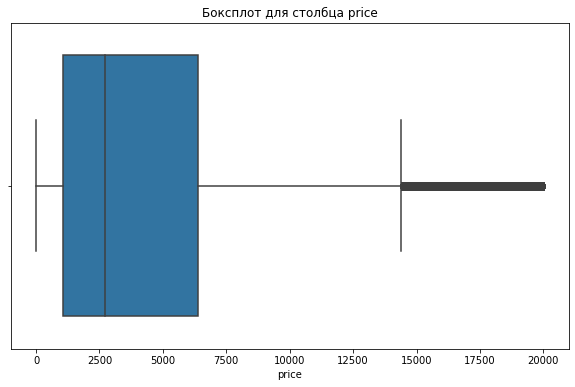

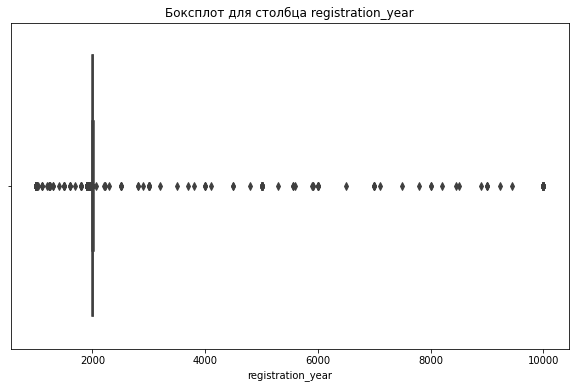

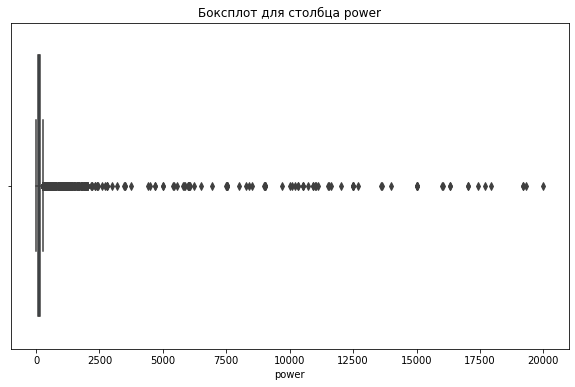

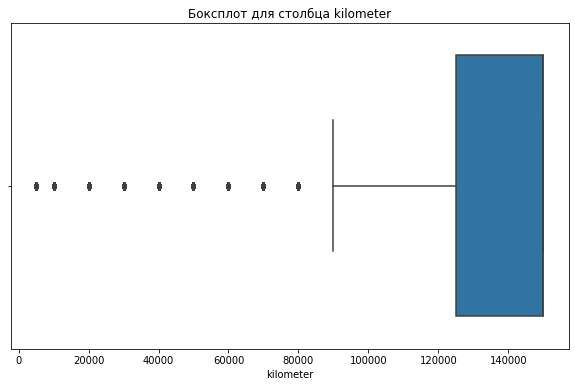

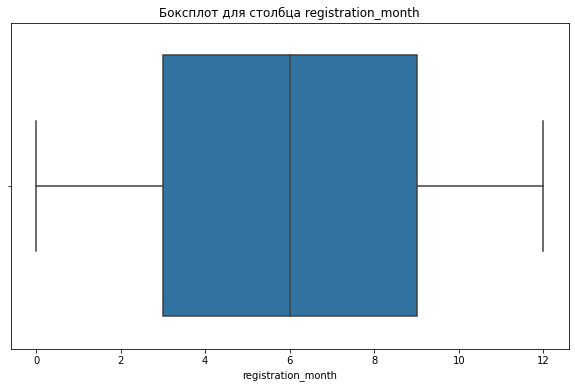

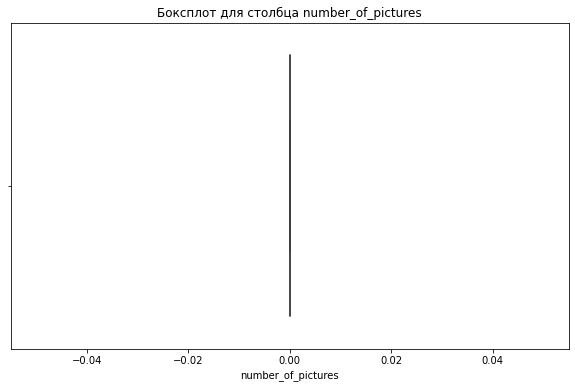

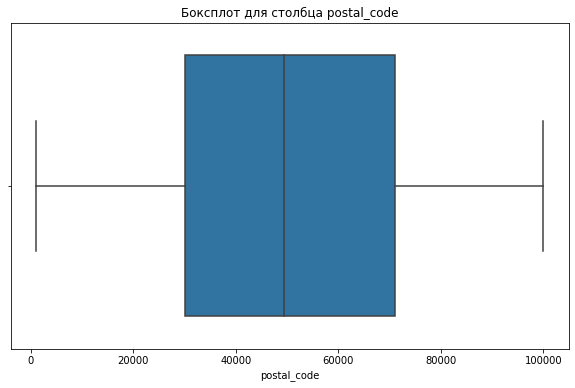

In [8]:
# определение числовых столбцов
numerical_columns = data.select_dtypes(include=['int64']).columns

# построение диаграмм boxplot для каждого числового столбца
for column in numerical_columns:
    plt.figure(figsize=(10, 6))
    sns.boxplot(x=data[column])
    plt.title(f'Боксплот для столбца {column}')
    plt.xlabel(column)
    plt.show()

Неверные значения (аномалии) имеются в столбцах года регистрации и мощности. Построим гистограммы и применим метод .describe()

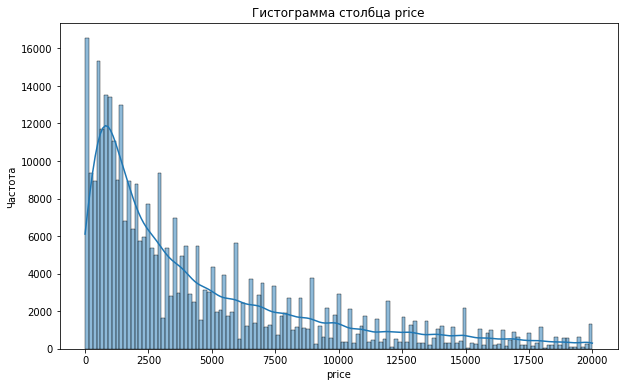

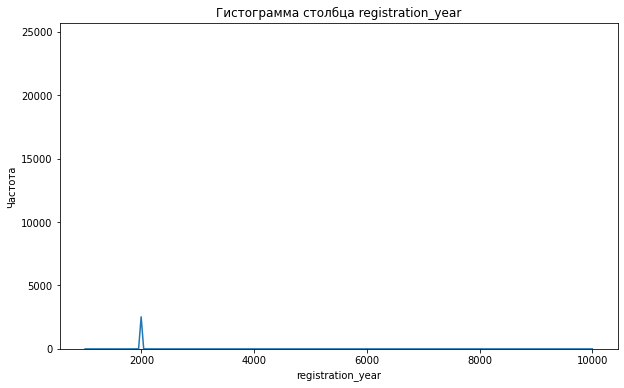

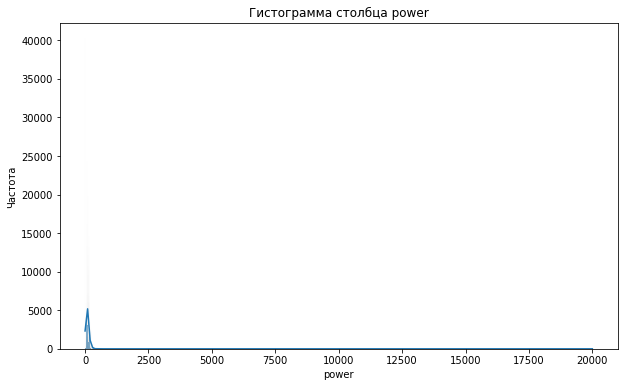

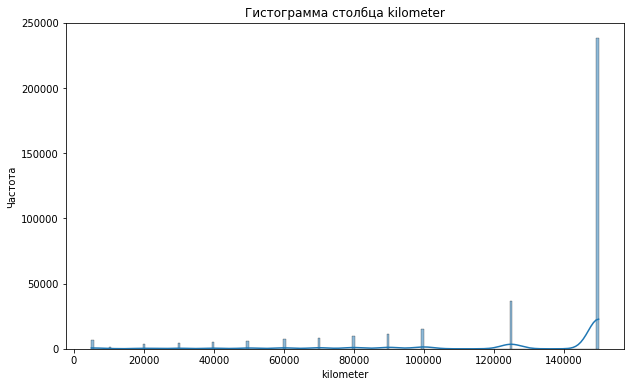

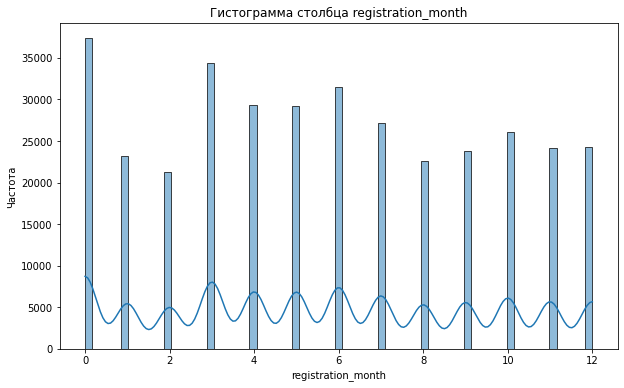

/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


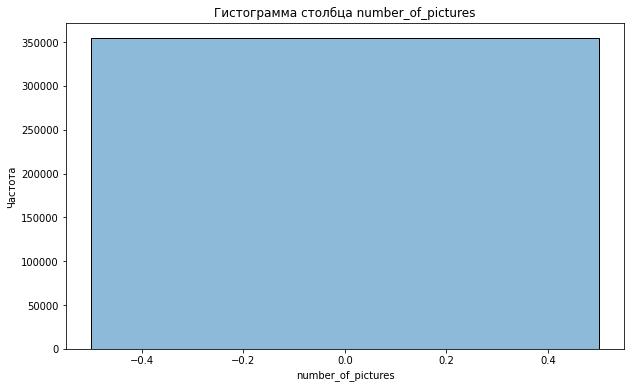

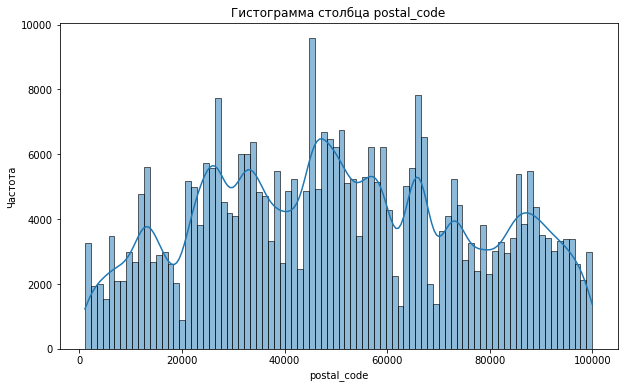

In [9]:
# Построение гистограмм
for column in numerical_columns:
    plt.figure(figsize=(10, 6))
    sns.histplot(data[column], kde=True)
    plt.title(f'Гистограмма столбца {column}')
    plt.xlabel(column)
    plt.ylabel('Частота')
    plt.show()

In [10]:
# применение .describe() к числовым столбцам
data[numerical_columns].describe()

,price,registration_year,power,kilometer,registration_month,number_of_pictures,postal_code
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


Построим гистограммы покрупнее, чтобы увидеть реальные диапазоны мощности и года регистрации автомобилей

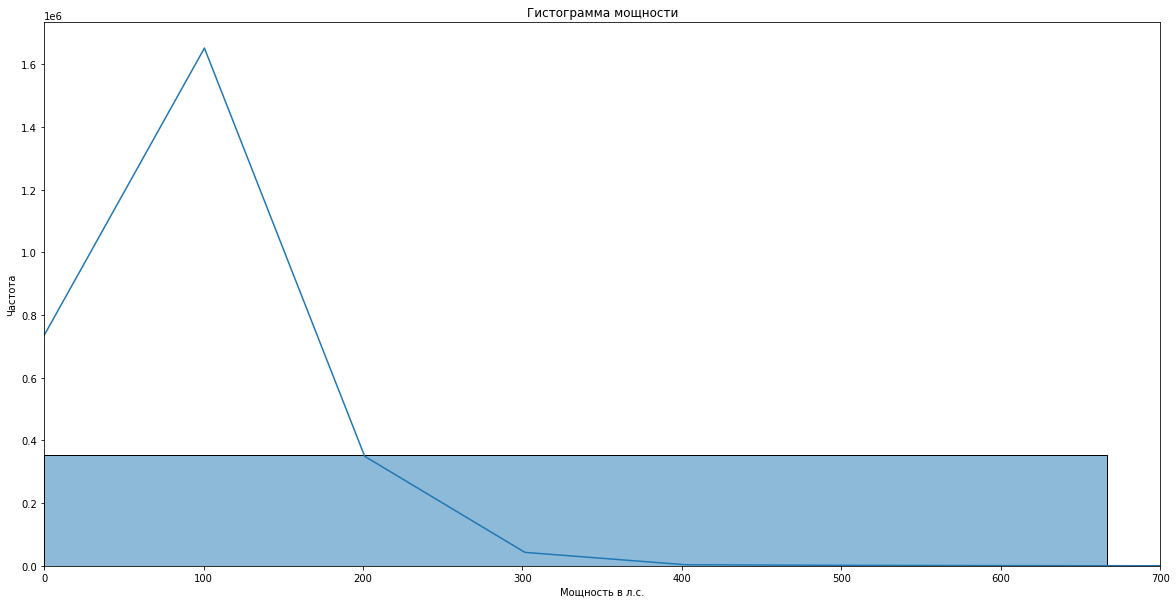

In [11]:
plt.figure(figsize=(20, 10))

# Построение гистограммы с мощностью
sns.histplot(data['power'], kde=True, bins=30)

# установка лимитов
plt.xlim(0, 700)

# Настройка заголовка и подписей осей
plt.title('Гистограмма мощности')
plt.xlabel('Мощность в л.с.')
plt.ylabel('Частота')

# Отображение графика
plt.show()

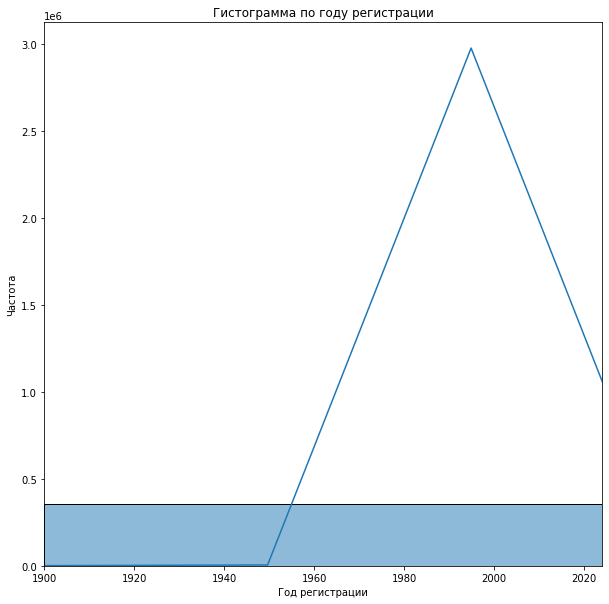

In [12]:
# Гистограмма для года регистрации с лимитами
plt.figure(figsize=(10, 10))
sns.histplot(data['registration_year'], kde=True, bins=30)
plt.xlim(1900, 2024)
plt.title('Гистограмма по году регистрации')
plt.xlabel('Год регистрации')
plt.ylabel('Частота')
plt.show()

Видим, что годы регистрации автомобилей: 1950-2020 гг., а диапазон мощности - до 700 л.с.

Посмотрим на уникальные значения категориальных столбцов

In [13]:
display(data['vehicle_type'].unique())
display(data['gearbox'].unique())
display(data['fuel_type'].unique())
display(data['model'].unique())
display(data['repaired'].unique())

array([nan, 'coupe', 'suv', 'small', 'sedan', 'convertible', 'bus',
       'wagon', 'other'], dtype=object)

array(['manual', 'auto', nan], dtype=object)

array(['petrol', 'gasoline', nan, 'lpg', 'other', 'hybrid', 'cng',
       'electric'], dtype=object)

array(['golf', nan, 'grand', 'fabia', '3er', '2_reihe', 'other', 'c_max',
       '3_reihe', 'passat', 'navara', 'ka', 'polo', 'twingo', 'a_klasse',
       'scirocco', '5er', 'meriva', 'arosa', 'c4', 'civic', 'transporter',
       'punto', 'e_klasse', 'clio', 'kadett', 'kangoo', 'corsa', 'one',
       'fortwo', '1er', 'b_klasse', 'signum', 'astra', 'a8', 'jetta',
       'fiesta', 'c_klasse', 'micra', 'vito', 'sprinter', '156', 'escort',
       'forester', 'xc_reihe', 'scenic', 'a4', 'a1', 'insignia', 'combo',
       'focus', 'tt', 'a6', 'jazz', 'omega', 'slk', '7er', '80', '147',
       '100', 'z_reihe', 'sportage', 'sorento', 'v40', 'ibiza', 'mustang',
       'eos', 'touran', 'getz', 'a3', 'almera', 'megane', 'lupo', 'r19',
       'zafira', 'caddy', 'mondeo', 'cordoba', 'colt', 'impreza',
       'vectra', 'berlingo', 'tiguan', 'i_reihe', 'espace', 'sharan',
       '6_reihe', 'panda', 'up', 'seicento', 'ceed', '5_reihe', 'yeti',
       'octavia', 'mii', 'rx_reihe', '6er', 'modus', 'fox'

array([nan, 'yes', 'no'], dtype=object)

В английском значения Petrol и Gasoline означают одно и тоже (автомобили с бензиновым двигателем). Наименования отличаются в различных англоязычных странах (США и Великобритания). Заменим одно значение на другое, чтобы было удобнее

In [14]:
data['fuel_type'] = data['fuel_type'].replace('petrol', 'gasoline')

In [15]:
# Замена значений 'rangerover' на 'range_rover' в столбце 'model'
data['model'] = data['model'].replace('rangerover', 'range_rover')

Пропуски в категориальных столбцах заменим на "Other" ("Другое")

In [16]:
categorical_columns = ['vehicle_type', 'gearbox', 'fuel_type', 'model', 'repaired']
data[categorical_columns] = data[categorical_columns].fillna('other')

Заменим аномальные значения в годе регистрации и мощности. Сгруппируем по модели и бренду и сделаем замену. Синхронизируем год регистрации с годом добавления объявления.
Также удалим строки с нулевой мощностью и ценой

In [17]:
# определение границ для регистрации года и мощности
registration_year_min = 1950

# преобразование столбца date_crawled в формат datetime
data['date_crawled'] = pd.to_datetime(data['date_crawled'], format='%Y-%m-%d %H:%M:%S')

# определение максимальной даты выгрузки данных
max_crawled_date = data['date_crawled'].max()

# установка верхней границы для registration_year на основе года максимальной даты выгрузки
registration_year_max = max_crawled_date.year

# удаление строк с нулевыми значениями мощности и цены
data = data[(data['power'] > 0) & (data['price'] > 0)]

# удаление строк с низкими значениями цен (например, менее 500 евро)
min_price_threshold = 500
data = data[data['price'] >= min_price_threshold]

# установка порогов для мощности
power_min = 50
power_max = 700

# Функция замены выбросов на медианное значение
def replace_outliers_with_median(group, lower_bound, upper_bound):
    median_value = group.median()
    return group.apply(lambda x: median_value if x < lower_bound or x > upper_bound else x)

# Применение функции к столбцу registration_year
data['registration_year'] = data.groupby(['brand', 'model'])['registration_year'].apply(
    replace_outliers_with_median, lower_bound=registration_year_min, upper_bound=registration_year_max)

# Применение функции к столбцу power
data['power'] = data.groupby(['brand', 'model'])['power'].apply(
    replace_outliers_with_median, lower_bound=power_min, upper_bound=power_max)

# Проверка изменений
display(data[['registration_year', 'power']].describe())

,registration_year,power
count,289652.000000,289652.000000
mean,2003.081146,123.028243
std,6.334147,53.517058
min,1950.000000,26.000000
25%,2000.000000,82.000000
50%,2003.000000,115.000000
75%,2007.000000,150.000000
max,2016.000000,700.000000


In [18]:
# Проверка пропущенных значений после обработки
display(data.isnull().sum())

date_crawled          0
price                 0
vehicle_type          0
registration_year     0
gearbox               0
power                 0
model                 0
kilometer             0
registration_month    0
fuel_type             0
brand                 0
repaired              0
date_created          0
number_of_pictures    0
postal_code           0
last_seen             0
dtype: int64

###### Можно удалить следующие неинформативные столбцы:
- 'date_crawled' - дата скачивания анкеты

- 'date_created' - дата создания анкеты

- 'last_seen' - последняя активность пользователя

- 'number_of_pictures' - количество фотографий (везде 0)

- 'postal_code' - почтовый индекс

- 'registration_month' - месяц регистрации автомобиля

In [19]:
# Удаление ненужных столбцов
data = data.drop(columns=['date_crawled', 'date_created', 'last_seen', 'number_of_pictures', 'registration_month', 'postal_code'])

In [20]:
# Проверка на наличие явных дубликатов
duplicate_rows = data.duplicated()

# Вывод количества дубликатов
print(f"Количество явных дубликатов: {duplicate_rows.sum()}")

# Если есть дубликаты, их можно удалить
if duplicate_rows.sum() > 0:
    data = data.drop_duplicates()
    print("Дубликаты удалены.")
else:
    print("Дубликатов не найдено.")

Количество явных дубликатов: 39521
Дубликаты удалены.


In [21]:
# осмотр данных после подготовки
display(data.head())
display(data.info())
display(data.describe())

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,repaired
1,18300,coupe,2011.0,manual,190.0,other,125000,gasoline,audi,yes
2,9800,suv,2004.0,auto,163.0,grand,125000,gasoline,jeep,other
3,1500,small,2001.0,manual,75.0,golf,150000,gasoline,volkswagen,no
4,3600,small,2008.0,manual,69.0,fabia,90000,gasoline,skoda,no
5,650,sedan,1995.0,manual,102.0,3er,150000,gasoline,bmw,yes


<class 'pandas.core.frame.DataFrame'>
Int64Index: 250131 entries, 1 to 354368
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   price              250131 non-null  int64  
 1   vehicle_type       250131 non-null  object 
 2   registration_year  250131 non-null  float64
 3   gearbox            250131 non-null  object 
 4   power              250131 non-null  float64
 5   model              250131 non-null  object 
 6   kilometer          250131 non-null  int64  
 7   fuel_type          250131 non-null  object 
 8   brand              250131 non-null  object 
 9   repaired           250131 non-null  object 
dtypes: float64(2), int64(2), object(6)
memory usage: 21.0+ MB


None

,price,registration_year,power,kilometer
count,250131.000000,250131.000000,250131.000000,250131.000000
mean,5196.671640,2003.152312,124.175882,126686.896066
std,4632.114199,6.479573,53.825103,37629.903874
min,500.000000,1950.000000,26.000000,5000.000000
25%,1600.000000,2000.000000,85.000000,125000.000000
50%,3500.000000,2004.000000,116.000000,150000.000000
75%,7499.000000,2007.000000,150.000000,150000.000000
max,20000.000000,2016.000000,700.000000,150000.000000


###### Корреляционный анализ

In [22]:
# Определение числовых и категориальных признаков
interval_cols = ['price', 'power']  # Непрерывные признаки
categorical_cols = ['vehicle_type', 'gearbox', 'fuel_type', 'model', 'brand', 'repaired']  # Категориальные признаки

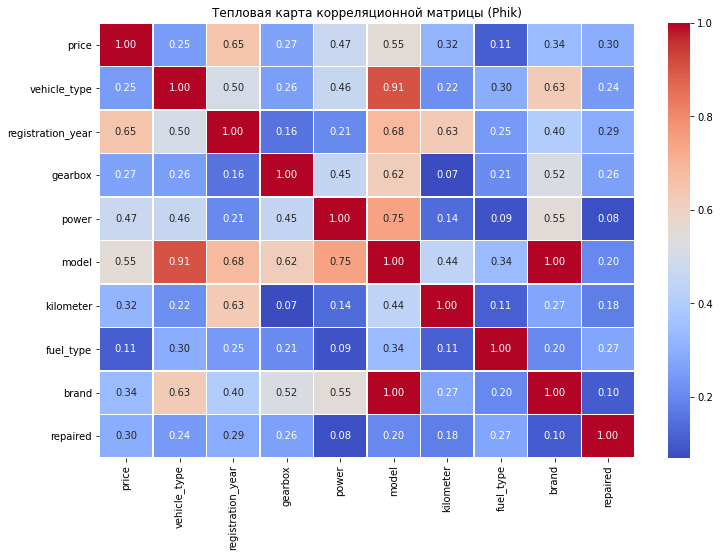

In [23]:
# Вычисление корреляционной матрицы с использованием phik
phik_matrix = data.phik_matrix(interval_cols=interval_cols)

# Построение тепловой карты для корреляционной матрицы
plt.figure(figsize=(12, 8))
sns.heatmap(phik_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Тепловая карта корреляционной матрицы (Phik)')
plt.show()

У нас есть полная ассоциация между model и brand, что указывает на мультиколлинеарность. В таком случае возможно стоит исключить один из этих признаков, чтобы избежать проблем в модели. Объединим эти признаки в один

In [24]:
# Создание нового признака путем объединения brand и model
data['brand_model'] = data['brand'] + '_' + data['model']

# Удаление исходных признаков brand и model
data = data.drop(['brand', 'model'], axis=1)

# Просмотр обновленного датасета
display(data.head(10))

,price,vehicle_type,registration_year,gearbox,power,kilometer,fuel_type,repaired,brand_model
1,18300,coupe,2011.0,manual,190.0,125000,gasoline,yes,audi_other
2,9800,suv,2004.0,auto,163.0,125000,gasoline,other,jeep_grand
3,1500,small,2001.0,manual,75.0,150000,gasoline,no,volkswagen_golf
4,3600,small,2008.0,manual,69.0,90000,gasoline,no,skoda_fabia
5,650,sedan,1995.0,manual,102.0,150000,gasoline,yes,bmw_3er
6,2200,convertible,2004.0,manual,109.0,150000,gasoline,no,peugeot_2_reihe
8,14500,bus,2014.0,manual,125.0,30000,gasoline,other,ford_c_max
9,999,small,1998.0,manual,101.0,150000,other,other,volkswagen_golf
10,2000,sedan,2004.0,manual,105.0,150000,gasoline,no,mazda_3_reihe
11,2799,wagon,2005.0,manual,140.0,150000,gasoline,yes,volkswagen_passat


###### Выполнено
- загружены данные
- обработаны пропуски, дубликаты и аномалии
- проведен корреляционный анализ

## Обучение моделей

In [25]:
# Определение X и y
X = data.drop('price', axis=1)  # Признаки
y = data['price']  # Целевой признак

# Определите признаки
numerical_features = ['registration_year', 'power', 'kilometer']
categorical_features = ['vehicle_type', 'gearbox', 'fuel_type', 'brand_model', 'repaired']

# Разделение данных на тренировочную и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [26]:
# Создание ColumnTransformer с настройкой OneHotEncoder
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore'), categorical_features)
    ]
)

In [27]:
# Оптимизация гиперпараметров для LGBMRegressor с использованием GridSearchCV
model_lgb = lgb.LGBMRegressor(random_state=42)

In [28]:
param_grid = {
    'n_estimators': [50, 100],
    'learning_rate': [0.01, 0.1],
    'num_leaves': [31, 50],
    'max_depth': [10, 20]
}

# Создание и обучение GridSearchCV
gs = GridSearchCV(model_lgb, param_grid, cv=3, scoring='neg_mean_squared_error', verbose=1, n_jobs=-1)
X_train_processed = preprocessor.fit_transform(X_train)  # Преобразуем X_train
gs.fit(X_train_processed, y_train)

# Извлечение лучшей модели и вычисление RMSE на кросс-валидации
best_lgb = gs.best_estimator_
best_score = (-gs.best_score_)**0.5  # Преобразование в RMSE

# Замер времени обучения лучшей модели
start_time = time.time()
best_lgb.fit(X_train_processed, y_train)
training_time_lgb = time.time() - start_time

# Замер времени предсказания на тренировочных данных
start_time = time.time()
y_pred_lgb_train = best_lgb.predict(X_train_processed)
prediction_time_lgb = time.time() - start_time

Fitting 3 folds for each of 16 candidates, totalling 48 fits


In [29]:
# Вывод результата на кросс-валидации
print(f"Лучший результат RMSE на кросс-валидации: {best_score:.2f}")
print(f"Время предсказания: {prediction_time_lgb:.2f}")
print(f"Время обучения: {training_time_lgb:.2f} секунд")

Лучший результат RMSE на кросс-валидации: 1753.89
Время предсказания: 2.41
Время обучения: 10.60 секунд


In [30]:
# Создаем функцию для оценки RMSE
rmse_scorer = make_scorer(mean_squared_error, squared=False)

# Замер времени обучения с кросс-валидацией
start_time = time.time()
model_lr = LinearRegression()
model_lr.fit(X_train_processed, y_train)
training_time_lr_cv = time.time() - start_time

# Среднее значение RMSE на кросс-валидации
cv_scores = cross_val_score(model_lr, X_train_processed, y_train, cv=3, scoring=rmse_scorer)
rmse_lr_cv = cv_scores.mean()

# Время предсказания для обучающей выборки (после обучения модели)
start_time = time.time()
y_pred_lr_train = model_lr.predict(X_train_processed)
prediction_time_lr = time.time() - start_time

/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [31]:
# Вывод результатов
print(f"Линейная регрессия - Среднее RMSE с кросс-валидации: {rmse_lr_cv:.2f}")
print(f"Время обучения на train выборке: {training_time_lr_cv:.2f} секунд")
print(f"Время предсказания: {prediction_time_lr:.2f} секунд")

Линейная регрессия - Среднее RMSE с кросс-валидации: 2709.30
Время обучения на train выборке: 58.36 секунд
Время предсказания: 0.21 секунд


###### Выводы
- Качество предсказаний: модель градиентного бустинга превосходит линейную регрессию по качеству предсказаний и удовлетворяет требованиям задачи

- Время предсказания: линейная регрессия делает предсказания быстрее на 2 секунды, но качество предсказаний не удовлетворяет требованиям задачи

- Время обучения: линейная регрессия обучается сильно медленнее, 58 секунд против 10

## Анализ моделей

In [32]:
print("Сравнение моделей:")
print(f"Линейная регрессия - RMSE: {rmse_lr_cv:.2f}, Время обучения: {training_time_lr_cv:.2f}, Время предсказания: {prediction_time_lr:.2f}s")
print(f"Модель градиентного бустинга - RMSE: {best_score:.2f}, Время обучения: {training_time_lgb:.2f}, Время предсказания: {prediction_time_lgb:.2f}s")

Сравнение моделей:
Линейная регрессия - RMSE: 2709.30, Время обучения: 58.36, Время предсказания: 0.21s
Модель градиентного бустинга - RMSE: 1753.89, Время обучения: 10.60, Время предсказания: 2.41s


In [33]:
# Создание таблицы с результатами
results = pd.DataFrame({
    'Модель': ['Линейная регрессия', 'Модель градиентного бустинга'],
    'Метрика RMSE': [rmse_lr_cv, best_score],
    'Время обучения (с)': [training_time_lr_cv, training_time_lgb],
    'Время предсказания (с)': [prediction_time_lr, prediction_time_lgb]
})

# Отображение таблицы
display(results)

,Модель,Метрика RMSE,Время обучения (с),Время предсказания (с)
0,Линейная регрессия,2709.304989,58.357697,0.205686
1,Модель градиентного бустинга,1753.889006,10.602734,2.408828


## Финальное предсказание на test-выборке и оценка RMSE

In [34]:
# Финальное предсказание на тестовой выборке
X_test_processed = preprocessor.transform(X_test)
y_pred_lgb_test = best_lgb.predict(X_test_processed)  # Предсказания на тестовой выборке
rmse_lgb_test = mean_squared_error(y_test, y_pred_lgb_test, squared=False)
print(f"Финальное RMSE на тестовой выборке: {rmse_lgb_test:.2f}")

Финальное RMSE на тестовой выборке: 1730.58


/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


###### Выводы
Модель градиентного бустинга является предпочтительной моделью для задачи, так как она удовлетворяет требованиям по RMSE. Не смотря на лучшее время предсказания в модели линейной регрессии, разница составляет чуть более 2 секунд, это незначительно быстрее.

Скорость обучения модели меньше более чем в 5 раз у модели LightGBM (58 секунд против 10 секунд) 

Учитывая метрику RMSE, которая на тренировочных и кросс-валидационных данных лучше у модели градиентного бустинга, то модель LightGBM намного предпочтительнее. Линейная регрессия не может быть использована, так как не удовлетворяет установленным требованиям по качеству предсказаний.

Финальный результат на тестовой выборке для модели LightGBM составил 1730.6, что менее 2500 и также удовлетворяет условиям задачи.